## BERT Twitter disinformation classifier
In this notebook a disinformation classifier for tweets is trained using a pre-trained BERT natural language processing model.

### Overview of notebook: 
1. Loading data
2. Explanatory data analysis
3. Data preparations
4. Tokenization
5. Fine-tune pre-trained BERT model and model predictions
6. Model perfomance on test data set
7. Export model predictions

To build this classifier an online tutorial was consulted: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894.

### Load libraries

In [1]:
import nltk
import torch
import gensim
import numpy as np
import pandas as pd

# BERT transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# notebook/markdown
from IPython.display import display, clear_output

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tensorflow/Keras tokenizer
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

# torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# tqdm
from tqdm.notebook import tqdm

### 1. Loading data

In [2]:
path = './twitter1516_final.csv'
df = pd.read_csv(path)
df.head()

,label,tweet_id,tweet,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
0,1,489800427152879616,malaysia airlines says it lost contact with pl...,95,2,0,0,1,15375121,72.567469,-0.3182
1,1,560474897013415936,for just $1 you can get a free jr. frosty with...,118,1,1,0,1,3673898,55.294333,0.8398
2,0,524928119955013632,police say they have located car belonging to ...,133,0,0,1,1,1274260,32.033388,-0.7269
3,1,518830518792892416,mexico security forces hunting 43 missing stud...,96,1,0,0,1,13955752,64.548896,-0.3400
4,1,551117430345711616,news saudi arabia's national airline planning ...,96,2,0,0,1,189683,24.726166,0.0000


### 2. Explanatory data analysis 
#### Lengths of tweets

In [3]:
tweet_ls = [tweet for tweet in df.tweet]

max_len = 0
tweet_len = []
for tweet in tweet_ls:
    tweet_len.append(len(tweet))

print('Number of tweets:', len(tweet_ls))
print('Max length of tweet:', max(tweet_len))
print('Mean length of tweets:', np.mean(tweet_len))

Number of tweets: 1057
Max length of tweet: 140
Mean length of tweets: 91.29801324503312


### 3. Data preperations
#### Selection and randomization

In [4]:
# select source tweets and prediction labels
df = df[['tweet','label']]

# randomize data frame
df = shuffle(df).reset_index(drop=True)
df.head()

,tweet,label
0,the president of argentina adopted a jewish te...,1
1,"it was a long, dark day in ottawa. a timeline ...",0
2,they found him shot dead and burned in his car...,1
3,someone spray painted a penis on a $2.4 mill b...,1
4,hewlett-packard will split into two companies ...,0


#### Split data intro train, validation and test set

In [5]:
# test set
train_val_df = df.sample(frac = 0.6)
test_df = df.drop(train_val_df.index)

# train and validation set
train_df = train_val_df.sample(frac = 0.8)
val_df = train_val_df.drop(train_df.index)

# reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('shape trainset:', train_df.shape)
print('shape valset:', val_df.shape)
print('shape testset:', test_df.shape)

shape trainset: (507, 2)
shape valset: (127, 2)
shape testset: (423, 2)


#### Export train, validation and test set to .tsv format

In [6]:
train_df.to_csv('./train.tsv', sep='\t', index=False)
val_df.to_csv('./val.tsv', sep='\t', index=False)
test_df.to_csv('./test.tsv', sep='\t', index=False)

#### Concatenate data

In [7]:
df = pd.concat([train_df, val_df, test_df])

#### Data Cleaning: Removing stopwords from all source tweets (train, validation and test set)

In [8]:
# dowload stopwords from nltk library
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# remove stopwords and words with ≤2 characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [10]:
# load stopwords from nltk
stop_words = stopwords.words('english')

# cleaning source tweets
df['cleaned'] = df['tweet'].apply(preprocess)

### Words in dataset after cleaning

In [11]:
words_ls = []
for i in df.cleaned:
    for j in i:
        words_ls.append(j)

words = len(list(set(words_ls)))
words

2671

### 4. Tokenization
#### Tokenize source tweets using Tensorflow's one-hot tokenization function

In [12]:
# tokenize source tweets 
tokenizer = Tokenizer(num_words = words)
tokenizer.fit_on_texts(train_df['tweet'])

In [13]:
# Create sequence of tokenized words for train, validation and test set 
train_sequences = tokenizer.texts_to_sequences(train_df['tweet'])
val_sequences = tokenizer.texts_to_sequences(val_df['tweet'])
test_sequences = tokenizer.texts_to_sequences(test_df['tweet'])

### 5. Fine-tune pre-trained BERT model
#### Load pre-trained BERT model

In [14]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

#### Create class for datasets

In [15]:
class TwitterDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv('./' + mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer
    
    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len

#### Initialize train, validation and test data set for transformation

In [16]:
# Initialize Datasets for Transformation
trainset = TwitterDataset('train', tokenizer=tokenizer)
valset = TwitterDataset('val', tokenizer=tokenizer)
testset = TwitterDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 507
valset size: 127
testset size:  423


#### Initialize sampling and observing tensors

In [17]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
ottawa shooting: how events unfolded, first shots fired at 9:52 a.m. at the war memorial URL URL

tokens: 
['[CLS]', 'ottawa', 'shooting', ':', 'how', 'events', 'unfolded', ',', 'first', 'shots', 'fired', 'at', '9', ':', '52', 'a', '.', 'm', '.', 'at', 'the', 'war', 'memorial', 'ur', '##l', 'ur', '##l', '[SEP]']

label: 0

--------------------

tokens_tensor: 
tensor([  101,  8166,  5008,  1024,  2129,  2824, 23959,  1010,  2034,  7171,
         5045,  2012,  1023,  1024,  4720,  1037,  1012,  1049,  1012,  2012,
         1996,  2162,  3986, 24471,  2140, 24471,  2140,   102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

label_tensor: 
0




#### Transforming dataset

In [19]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [20]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([16, 31]) 
tensor([[  101,  8166,  5008,  1024,  2129,  2824, 23959,  1010,  2034,  7171,
          5045,  2012,  1023,  1024,  4720,  1037,  1012,  1049,  1012,  2012,
          1996,  2162,  3986, 24471,  2140, 24471,  2140,   102,     0,     0,
             0],
        [  101,  1996,  3010,  5268,  2915,  2012,  1996,  2162,  3986,  1999,
          8166,  2038,  2351,  1010,  2429,  2000,  2048,  2372,  1997,  3323,
          1012,  2444,  9927,  1024, 24471,  2140,   102,     0,     0,     0,
             0],
        [  101,  1996,  2034,  2236,  2730,  1999,  1037,  4337,  4224,  2144,
          5148,  1010,  2009,  2003,  1037, 19817, 21055,  3723,  2008,  8112,
          2106,  2025,  5463,  2350,  2236,  7157, 11006,  1521,  1055,  6715,
           102],
        [  101,  7172,  1064, 17346,  2915,  2757,  1999,  3323,  2044,  5268,
          2915,  2012,  2120,  2162,  3986,  1024, 24471,  2140,  1001, 13581,
         14517,  1001, 27178,  2

#### Model Construction

In [21]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout          Dropout(p=0.1, inplace=False)
classifier       Linear(in_features=768, out_features=2, bias=True)


In [22]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### Fine-tuning BERT and make predictions 

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

device: cpu


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [24]:
torch.save(model, './best_model.pth')
print('Model saved!')

Model saved!


### 6. Model performance on test data set

Acc:  0.789598108747045


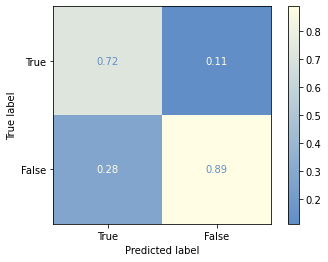

In [25]:
true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())


cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

cmap0 = mpl.colors.LinearSegmentedColormap.from_list(
        'unevently divided', ['#618EC7','#fffde4'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'False'])
disp.plot(cmap=cmap0)

print('Acc: ', accuracy_score(predictions,true))

#### Dataframe with ground truth and predicted labels

In [27]:
df = pd.DataFrame({"pred_label": predictions})
df_true = pd.DataFrame({"label": true})

df_pred = pd.concat([test_df.loc[:, ['tweet']], 
                     df_true.loc[:, ['label']], 
                     df.loc[:, 'pred_label']], axis=1)
df_pred.head()

,tweet,label,pred_label
0,"it was a long, dark day in ottawa. a timeline ...",0,0
1,hewlett-packard will split into two companies ...,0,0
2,white house lit in rainbow colors after high c...,0,0
3,breaking: 10 reportedly shot dead at paris hq ...,0,0
4,steve jobs was adopted. his biological father ...,1,1


### 7. Export model predictions

In [28]:
df_pred.to_csv('./pred_BERT.csv', index=False)